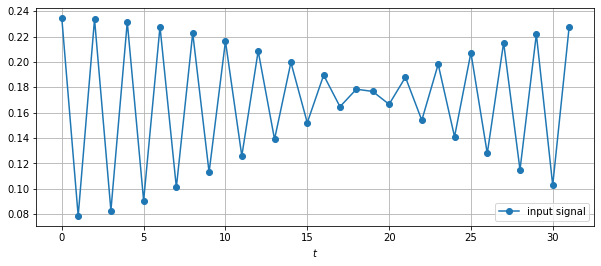

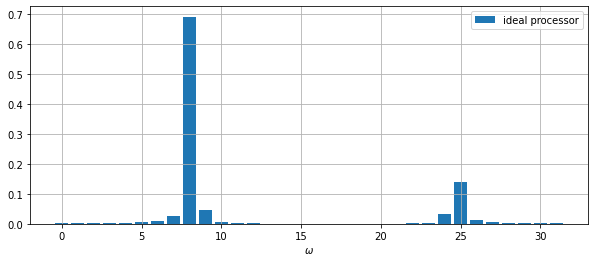

In [1]:
from qat.qpus import get_default_qpu
from qat.lang.AQASM import *
from qat.lang.AQASM.qftarith import QFT
from matplotlib import pyplot as plt
from functools import reduce


import numpy as np
from qat.core.simutil import rev_bits

# the prepare_ft_signal and format_qft_output comes from SC19 demo
def prepare_ft_signal(nqbits):
    """Prepare a normalized input signal for the FT"""
    N = 2**nqbits
    om = 0.5
    t_max = 100
    w_max = 2*np.pi*N/t_max
    times = np.linspace(0,t_max,N)
    omegas = np.linspace(0, w_max, N)

    # signal with two frequencies at om and 3*om
    f = lambda t : 4*np.exp(1j*t*om) + 2*np.exp(1j*3*t*om) #+ np.exp(1j*5*t*om)
    signal = np.array([f(t) for t in times])
    signal = signal/np.linalg.norm(signal)
    return signal

def format_qft_output(psi_qft):
    """some manipulations : reversing order + shift by 1"""
    psi_qft_copy_1 = np.zeros(psi_qft.shape, np.complex_)
    nqbits = int(np.log2(psi_qft.shape[0]))
    for ind in range(psi_qft_copy_1.shape[0]):
        psi_qft_copy_1[rev_bits(ind, nqbits)] = psi_qft[ind]
    psi_qft_copy = np.array(list(reversed(psi_qft_copy_1)))
    return np.roll(psi_qft_copy, 1)

nqbits = 5
 
def imprint_vector(vector):
    N=int(np.log(len(vector))/np.log(2))
 
    return (vector*reduce(np.kron, [np.array([[1,1],[1,-1]]) for i in range(N)])).transpose()
 
def SignalStatePreparation(v):
    n = int(np.log(len(v))/np.log(2))
    return AbstractGate("StatePrep", [], arity=n, matrix_generator=lambda: imprint_vector(v))()
 
# Lets prepare the state, and apply a QFT 
prog = Program()
qbits = prog.qalloc(nqbits)
vector = prepare_ft_signal(nqbits)
prog.apply(SignalStatePreparation(vector), qbits)
prog.apply(QFT(nqbits), qbits) #comment this line to display the initial vector.
circuit = prog.to_circ()
# Now we juste need to simulate the circuit and gather the final amplitudes
qpu = get_default_qpu()
results = qpu.submit(circuit.to_job())
resprobs = np.zeros(shape=(2**nqbits))
for result in results.raw_data: resprobs[result.state.int]=result.probability

%qatdisplay circuit --svg --depth=1
    
# And display everything nicely
plt.figure(figsize=(10,4))
plt.plot(np.array(range(2**nqbits)), np.abs(prepare_ft_signal(nqbits)), marker='o', label="input signal")
plt.legend(); plt.grid(); plt.xlabel(r"$t$"); 
plt.show()
plt.figure(figsize=(10,4))
plt.bar(np.array(range(2**nqbits)), np.abs(format_qft_output(resprobs)), width=4/5, label="ideal processor")
plt.legend(); plt.grid(); plt.xlabel(r"$\omega$"); 
plt.show()
